# Pseudo-Hamiltonian neural networks for PDEs

This notebook shows how PHNN can be used to model the systems considered in ["Pseudo-Hamiltonian neural networks for learning partial differential equations"](https://arxiv.org/abs/2304.14374), and a couple more.

In [1]:
# Uncomment for local install: 
# %pip install -e ../phlearn 

In [2]:
import numpy as np
import torch
import phlearn.phsystems.pde as phsys
import phlearn.phnns as phnn
import matplotlib.pyplot as plt
from phlearn.utils import create_video
from scipy.sparse import diags, spdiags

ttype = torch.float32
torch.set_default_dtype(ttype)

In [3]:
make_videos = False

#### Decide on the system to learn

Decide on the system to model, whether it should be affected by an external force, and whether the PHNN model should be *informed*, i.e. whether the correct difference operators and what variables the force depends on should be known:

In [4]:
system = 'kdv' # kdv, bbm, heat, perona-malik, cahn-hilliard, allen-cahn
external_forces = True
informed_phnn = False

#### Set up the system

Below is an example of how to set up a Hamiltonian PDE system using the PseudoHamiltonianPDESystem() class. The below block sets up the differential equation that will be used to generate the data.

In [5]:
if system == 'kdv':
    period = 20
    spatial_points = 100
    x = np.linspace(0, period-period/spatial_points, spatial_points)
    if external_forces:      
        def force(u, t):
            t = np.reshape(t,(-1,1))
            return .6*np.sin(2*2*np.pi/period*x-t).reshape(u.shape)
        time, space, state = True, True, False
        training_states = 200
        t_max = 2.
    else:
        force = None
        training_states = 10
        t_max = .05
    dt = .05
    nu = 0.3
    PDE_system = phsys.KdVSystem(x=x, nu=nu, external_forces=force)
    PDE_system_no_force = phsys.KdVSystem(x=x, nu=nu, external_forces=None)
    kernel_sizes = [1, 3, 0 if nu==0 else 1, int(external_forces)]
    k1, k2 = 1., .75
    d1, d2 = .25, .5
    eta = 6.
    u0 = (-6./-eta)*2*k1**2 * 1/np.cosh(k1*(x-period*d1))**2
    u0 += (-6./-eta)*2*k2**2 * 1/np.cosh(k2*(x-period*d2))**2
    t_test = np.linspace(0, 2, 201)
elif system == 'bbm':
    period = 50
    spatial_points = 100
    x = np.linspace(0, period-period/spatial_points, spatial_points)
    if external_forces:
        def force(u, t):
            t = np.reshape(t,(-1,1))
            return (np.sin(1.*t)*.1*u).reshape(u.shape)
        time, space, state = True, False, True
        training_states = 250
        t_max = 10.
    else:
        force = None
        training_states = 10
        t_max = .4
    dt = .4
    nu = 0
    kernel_sizes = [3, 3, 0 if nu==0 else 1, int(external_forces)]
    PDE_system = phsys.BBMSystem(x=x, nu=nu, external_forces=force)
    PDE_system_no_force = phsys.BBMSystem(x=x, nu=nu, external_forces=None)
    c1, c2 = 2.5, 1.5
    d1, d2 = .25, .5
    P = (x[-1]-x[0])*x.size/(x.size-1)
    sech = lambda a: 1/np.cosh(a)
    u0 = 3*(c1-1) * sech(1/2*np.sqrt(1 - 1/c1)*(x-P*d1))**2
    u0 += 3*(c2-1) * sech(1/2*np.sqrt(1 - 1/c2)*(x-P*d2))**2
    t_test = np.linspace(0, 8, 401)
elif system == 'heat' or system == 'perona-malik':
    period = 6
    spatial_points = 300
    x = np.linspace(0, period-period/spatial_points, spatial_points)
    if external_forces:
        def force(u, t):
            return 10*np.sin(2*2*np.pi/period*x)
        time, space, state = False, True, False
    else:
        force = None
    training_states = 50
    t_max = 0.005
    dt = .001
    kernel_sizes = [1, 0, 1, int(external_forces)]
    if system == 'heat':
        PDE_system = phsys.HeatEquationSystem(x=x, external_forces=force)
        PDE_system_no_force = phsys.HeatEquationSystem(x=x, external_forces=None)
    else:
        PDE_system = phsys.PeronaMalikSystem(x=x, external_forces=force)
        PDE_system_no_force = phsys.PeronaMalikSystem(x=x, external_forces=None)
    a = 1
    d1, d2 = 1, 2.
    k1, k2 = 2., 15.
    n1, n2 = 30., 0.15
    P = (x[-1]-x[0])*x.size/(x.size-1)
    u0 = a - np.tanh(n1*(x-d1)) + np.tanh(n1*(x-P+d1))
    u0 += - np.tanh(n1*(x-d2)) + np.tanh(n1*(x-P+d2))
    u0 += n2*np.sin(k1*np.pi*x)**2*np.sin(k2*np.pi*x)
    t_test = np.linspace(0, .04, 201)
elif system == 'cahn-hilliard':
    period = 1
    spatial_points = 100
    x = np.linspace(0, period-period/spatial_points, spatial_points)
    if external_forces:
        def force(u, t):
            return np.where((0.3 < x) & (x < 0.7), 30*u, 0)
        time, space, state = False, True, True
    else:
        force = None
    training_states = 40
    t_max = 0.004
    dt = .004
    kernel_sizes = [1, 0, 3, int(external_forces)]
    PDE_system = phsys.CahnHilliardSystem(x=x, external_forces=force)
    PDE_system_no_force = phsys.CahnHilliardSystem(x=x, external_forces=None)
    a1, a2 = 0.01, 0.02
    a3, a4 = 0.1, 0.06
    k1, k2, k3, k4 = 1, 2, 2, 5
    P = (x[-1]-x[0])*x.size/(x.size-1)
    u0 = a1*np.cos(2*k1*np.pi/P*x)
    u0 += a2*np.cos(2*k2*np.pi/P*x)
    u0 += a3*np.sin(2*k3*np.pi/P*x)
    u0 += a4*np.sin(2*k4*np.pi/P*x)
    t_test = np.linspace(0, .02, 201)
elif system == 'allen-cahn':
    period = 6
    spatial_points = 300
    x = np.linspace(0, period-period/spatial_points, spatial_points)
    if external_forces:
        def force(u, t):
            return 1*np.sin(2*2*np.pi/period*x)
        time, space, state = False, True, False
    else:
        force = None
    training_states = 20
    t_max = .01
    dt = .005
    kernel_sizes = [1, 0, 1, int(external_forces)]
    PDE_system = phsys.AllenCahnSystem(x=x, external_forces=force)
    PDE_system_no_force = phsys.AllenCahnSystem(x=x, external_forces=None)
    d1, d2 = .3, .7
    k1, k2 = 1., .6
    P = (x[-1]-x[0])*x.size/(x.size-1)
    u0 = k1*np.cos(2*np.pi/P*(x-d1*P))
    u0 += k2*np.cos(2*np.pi/P*(x-d2*P))
    t_test = np.linspace(0, 5, 101)

#### Generate training data

Use the `PDE_system` instance to generate training data, which are numerical solutions to the exact PDE.  

In [6]:
def get_training_data(system, data_points=20, dt=.05, tmax=.05, x=x):
    nt = round(tmax / dt)
    t_axis = np.linspace(0, tmax, nt + 1)
    ntrajectories_train = int(np.ceil(data_points / nt))
    traindata = phnn.generate_dataset(system, ntrajectories_train, t_axis, xspatial=x)
    return traindata, t_axis

traindata, t_axis = get_training_data(PDE_system, training_states, dt, t_max, x)

  0%|                                                  | 0/5 [00:00<?, ?it/s]/usr/local/Caskroom/miniforge/base/envs/phnn_pde/lib/python3.10/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")
100%|██████████████████████████████████████████| 5/5 [00:03<00:00,  1.39it/s]


#### Set up the pseudo-Hamiltonian neural network
We set the kernel sizes of the operators applied to the left-hand side of the PDE, the variational derivative of the Hamiltonian, and the variational derivative of the dissipation integral, respectively.

We will allow additional keyword arguments to be passed to PseudoHamiltonianPDENN() so we have the option of adding a dissipative term and an external force to the model.

In [7]:
def setup_pseudo_hamiltonian_nn(kernel_sizes, **kwargs):
    phmodel = phnn.PseudoHamiltonianPDENN(
        spatial_points,
        kernel_sizes,
        **kwargs,
    )
    return phmodel

if external_forces or not informed_phnn:
    ext_forces_nn = phnn.PDEExternalForcesNN(spatial_points, hidden_dim=100,
                                             timedependent = time if informed_phnn else True,
                                             spacedependent = space if informed_phnn else True,
                                             statedependent = state if informed_phnn else True,
                                             period=period)
else:
    ext_forces_nn = None

phmodel = setup_pseudo_hamiltonian_nn(kernel_sizes = kernel_sizes if informed_phnn else [3, 3, 3, 1],
                                      skewsymmetric_matrix=PDE_system.skewsymmetric_matrix_flat if informed_phnn else None,
                                      dissipation_matrix=PDE_system.dissipation_matrix_flat if informed_phnn else None,
                                      lhs_matrix=PDE_system.lhs_matrix_flat if informed_phnn else None,
                                      external_forces_est=ext_forces_nn)

#### Setup a baseline model
To compare against ConservativeDissiaptiveNN() , we will create a baseline model which will approximate the dynamics using a standard fully connected multilayer perceptron. 

In [8]:
def setup_baseline_nn(**kwargs):
    baseline_nn = phnn.PDEBaselineNN(spatial_points, **kwargs)
    basemodel = phnn.DynamicSystemNN(spatial_points, baseline_nn)
    return basemodel

basemodel = setup_baseline_nn()

#### Train the models

In [9]:
def train_models(*models, epochs=200, batch_size=32, **kwargs):
    for model in models:
        model, _ = phnn.train(
            model,
            integrator="midpoint",
            traindata=traindata,
            epochs=epochs,
            batch_size=batch_size,
            **kwargs
        )
    return models

phmodel, basemodel = train_models(phmodel, basemodel, epochs=1000)

  0%|                                               | 0/1000 [00:00<?, ?it/s]/usr/local/Caskroom/miniforge/base/envs/phnn_pde/lib/python3.10/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|█████████████| 1000/1000 [01:26<00:00, 11.53it/s, epoch=999, loss=0.183]


#### Plot the results

We compare the learned model against the true PDE by integrating from an initial condition not in the training data and on a longer time period thain in the training data.

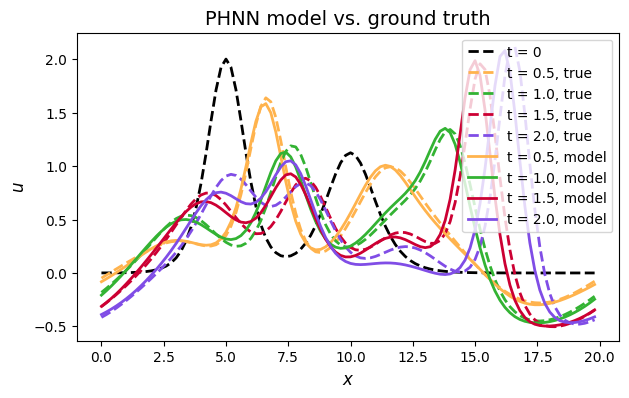

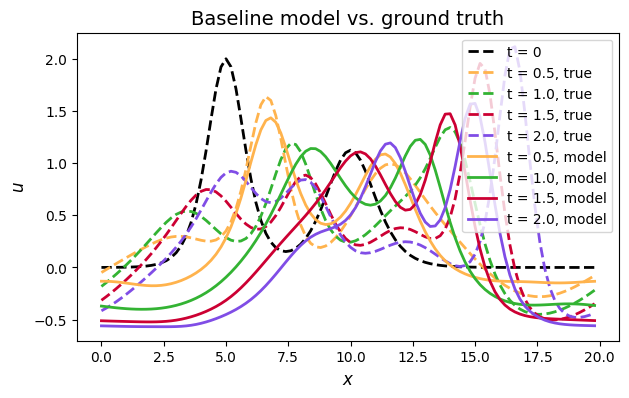

In [10]:
def get_solutions(system, phmodel, basemodel, u0, t_axis):
    u_exact, *_ = system.sample_trajectory(t_axis, x0=u0)
    u_phnn, _ = phmodel.simulate_trajectory(integrator=False, t_sample=t_axis, x0=u0, xspatial=x)
    if basemodel is not None:
        u_baseline, _ = basemodel.simulate_trajectory(
            integrator=False, t_sample=t_axis, x0=u0, xspatial=x
        )
    else:
        u_baseline = None
    return u_exact, u_phnn, u_baseline


def plot_solutions(u_exact, u_model, t_axis, model='', y=None):
    N = u_exact.shape[0]
    fig = plt.figure(figsize=(7,4))
    lw = 2
    colors = [(0,0.4,1),(1,0.7,0.3),(0.2,0.7,0.2),(0.8,0,0.2),(0.5,0.3,.9)]
    if N > 1:
        plt.plot(x, u_exact[0,:], 'k--', linewidth=lw, label='t = 0')
        plt.plot(x, u_exact[int(N/4),:], color = colors[1], linestyle='--', linewidth=lw, label=f't = {1/4*t_axis[-1]}, true')  
        plt.plot(x, u_exact[int(N/2),:], color = colors[2], linestyle='--', linewidth=lw, label=f't = {1/2*t_axis[-1]}, true')  
        plt.plot(x, u_exact[int(3*N/4),:], color = colors[3], linestyle='--', linewidth=lw, label=f't = {3/4*t_axis[-1]}, true')  
        plt.plot(x, u_exact[-1,:], color = colors[4], linestyle='--', linewidth=lw, label=f't = {t_axis[-1]}, true')  
        plt.plot(x, u_model[int(N/4),:], color = colors[1], linestyle='-', linewidth=lw, label=f't = {1/4*t_axis[-1]}, model')  
        plt.plot(x, u_model[int(N/2),:], color = colors[2], linestyle='-', linewidth=lw, label=f't = {1/2*t_axis[-1]}, model')  
        plt.plot(x, u_model[int(3*N/4),:], color = colors[3], linestyle='-', linewidth=lw, label=f't = {3/4*t_axis[-1]}, model')  
        plt.plot(x, u_model[-1,:], color = colors[4], linestyle='-', linewidth=lw, label=f't = {t_axis[-1]}, model')
    else:
        plt.plot(x, u_exact[0,:], 'k--', linewidth=lw, label='True')
        plt.plot(x, u_model[0,:], color = colors[4], linestyle='-', linewidth=lw, label='Model')
    plt.xlabel('$x$', fontsize=12)
    plt.ylabel('$u$' if y is None else y, fontsize=12)
    plt.title(model+' model vs. ground truth', fontsize=14)
    plt.legend()
    plt.show()

u_exact, u_phnn, u_baseline = get_solutions(PDE_system, phmodel, basemodel, u0, t_test)
plot_solutions(u_exact, u_phnn, t_test, 'PHNN')
plot_solutions(u_exact, u_baseline, t_test, 'Baseline')

In [11]:
if make_videos:
    create_video([u_exact, u_phnn, u_baseline], ['Ground truth', 'PHNN', 'Baseline'], x_axis=x,
                 file_name=system+'.gif', output_format='GIF')

#### Removing the forces

Since we learned the external forces by a separate neural network in the PHNN model, we can remove this from the model and compare to the exact system without forces:

In [12]:
u_exact, u_phnn, u_baseline = get_solutions(PDE_system, phmodel, basemodel, u0, t_test)

In [13]:
phmodel_su = setup_pseudo_hamiltonian_nn(kernel_sizes=kernel_sizes,
                                               skewsymmetric_matrix=phmodel.S(),
                                               dissipation_matrix=phmodel.R(),
                                               lhs_matrix=phmodel.A(),
                                               hamiltonian_true=phmodel.hamiltonian,
                                               grad_hamiltonian_true=phmodel.dH,
                                               dissintegral_true=phmodel.dissintegral,
                                               grad_dissintegral_true=phmodel.dV,
                                               external_forces_true=phmodel.external_forces
                                              )

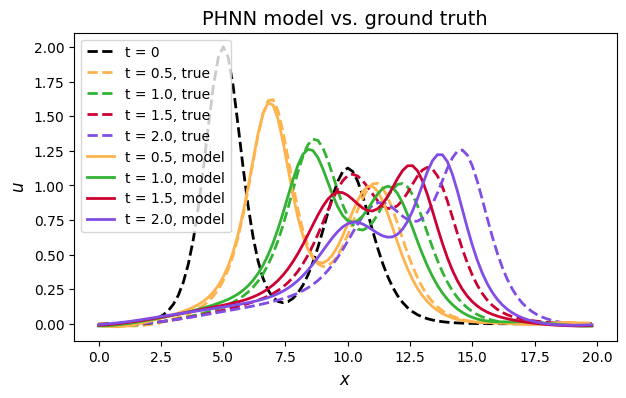

In [14]:
phmodel_no_force = setup_pseudo_hamiltonian_nn(kernel_sizes=kernel_sizes[:3]+[0] if informed_phnn else [3, 3, 3, 0],
                                               skewsymmetric_matrix=phmodel.S(),
                                               dissipation_matrix=phmodel.R(),
                                               lhs_matrix=phmodel.A(),
                                               hamiltonian_true=phmodel.hamiltonian,
                                               grad_hamiltonian_true=phmodel.dH,
                                               dissintegral_true=phmodel.dissintegral,
                                               grad_dissintegral_true=phmodel.dV
                                              )

u_exact_no_force, u_phnn_no_force, _ = get_solutions(PDE_system_no_force, phmodel_no_force, None, u0, t_test)
plot_solutions(u_exact_no_force, u_phnn_no_force, t_test, 'PHNN')

In [15]:
if make_videos:
    create_video([u_exact_no_force, u_phnn_no_force], ['Ground truth', 'PHNN'],
                 x_axis=x, file_name=system+'_no_force.gif', output_format='GIF')